In [2]:
import pandas as pd
import numpy as np

tweet = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [3]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
#Only consider "tweet" and "target"
del tweet['id']
del tweet['keyword']
del tweet['location']
tweet.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# install packages 
# !pip install inflect
# !pip install contractions

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
#importing required libraries
import nltk
import inflect
import contractions
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
# First function is used to denoise text
def denoise_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Replace contractions in the text. For ex. didn't -> did not
    text = contractions.fix(text)
    return text

In [17]:
# Text normalization includes many steps.
# Each function below serves a step.
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas
def normalize_text(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words


use word_tokenize from NLTK to tokenize the text

In [18]:
# Tokenize tweet into words
def tokenize(text):
    return nltk.word_tokenize(text)


apply function to our dataset using a text_prepare function. 

In [15]:
def text_prepare(text):
    text = denoise_text(text)
    text = ' '.join([x for x in normalize_text(tokenize(text))])
    return text
tweet['text'] = [text_prepare(x) for x in tweet['text']]
le = LabelEncoder()
tweet['target'] = le.fit_transform(tweet['target'])
tweet.head()

,text,target
0,dee reason earthquak may allah forg us,1
1,forest fir near la rong sask canad,1
2,resid ask shelt plac evacu shelt plac ord expect,1
3,thirteen thousand peopl receiv wildfir evacu o...,1
4,get send photo ruby alask smok wildfir pour sc...,1


# Model building

We use Keras library to build a recurrent neural network based on bidirectional LSTMs.
We use pre-trained GloVe embeddings to make the embedding dictionary

In [19]:
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [22]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    # pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file 
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    f = open("../input/glove6b50dtxt/glove.6B.50d.txt",encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [23]:
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequebtial model
    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    # Add the fully connected layer with 256 nurons and relu activation
    model.add(Dense(256, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [25]:
X = tweet.text
y = tweet.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Preparing model input ...
Found 17286 unique tokens.
(7613, 500)
Total 400000 word vectors.
Done!
Building Model!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           864350    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 64)           21248     
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 500, 64)           24832     
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 500, 64)           24832     
______

# Training and Evaluation

In [26]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [28]:
history = model.fit(X_train_Glove, y_train,
                           validation_data=(X_test_Glove,y_test),
                           epochs=5,
                           batch_size=128,
                           verbose=1)

Epoch 1/5
42/42 [==============================] - 130s 3s/step - loss: 0.6547 - accuracy: 0.6042 - val_loss: 0.5619 - val_accuracy: 0.7220
Epoch 2/5
42/42 [==============================] - 128s 3s/step - loss: 0.5441 - accuracy: 0.7386 - val_loss: 0.5153 - val_accuracy: 0.7570
Epoch 3/5
42/42 [==============================] - 128s 3s/step - loss: 0.4943 - accuracy: 0.7761 - val_loss: 0.4957 - val_accuracy: 0.7824
Epoch 4/5
42/42 [==============================] - 128s 3s/step - loss: 0.4384 - accuracy: 0.8157 - val_loss: 0.5354 - val_accuracy: 0.7653
Epoch 5/5
42/42 [==============================] - 128s 3s/step - loss: 0.3975 - accuracy: 0.8343 - val_loss: 0.5130 - val_accuracy: 0.7728


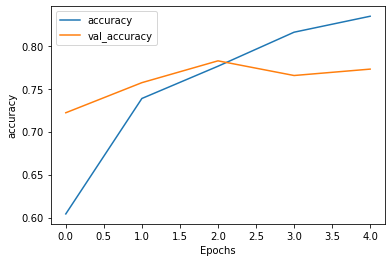

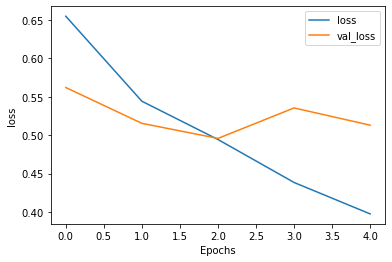

In [29]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [30]:
print("\n Evaluating Model ... \n")
predicted = model.predict_classes(X_test_Glove)
print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1341
           1       0.73      0.72      0.72       943

    accuracy                           0.77      2284
   macro avg       0.77      0.77      0.77      2284
weighted avg       0.77      0.77      0.77      2284



